In [1]:
%load_ext autoreload
%autoreload 2

# Exploratory data analysis

In [2]:
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
import sys
import numpy as np
import jax
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
fn = './data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_json(fn)
len(data)

3000000

Text(0.5, 1.0, 'Adaptation of RNA_2')

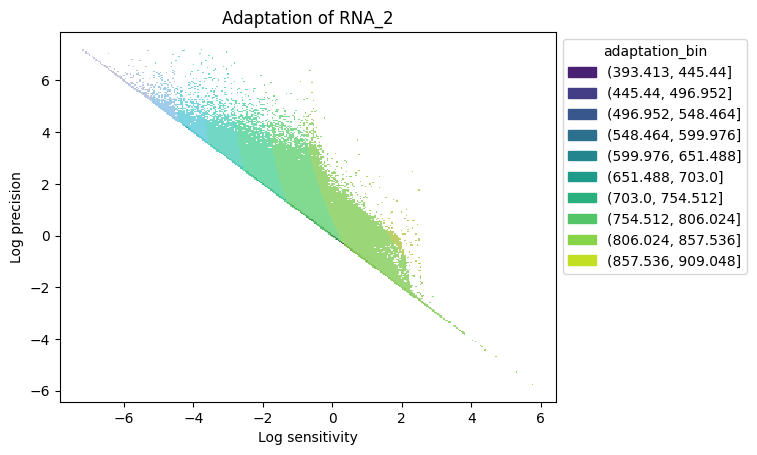

In [4]:
filt = data['sample_name'] == 'RNA_2'
data['adaptation'] = calculate_adaptation(data['sensitivity_wrt_species-6'].to_numpy(), data['precision_wrt_species-6'].to_numpy())
data['adaptation_bin'] = pd.cut(data['adaptation'], bins=10)
data['adaptation_bins'] = data['adaptation_bin'].apply(lambda x: x.mid).astype(float)
g = sns.histplot(data[filt], x='Log sensitivity', y='Log precision', hue='adaptation_bin', palette='viridis')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Adaptation of RNA_2')

In [5]:
exclude_cols = ['RMSE', 'num_interacting', 'num_self_interacting', 'circuit_name']
numerical_columns = data[data.columns.difference(exclude_cols)].select_dtypes(include=[np.number]).columns.tolist()
len(numerical_columns)

20

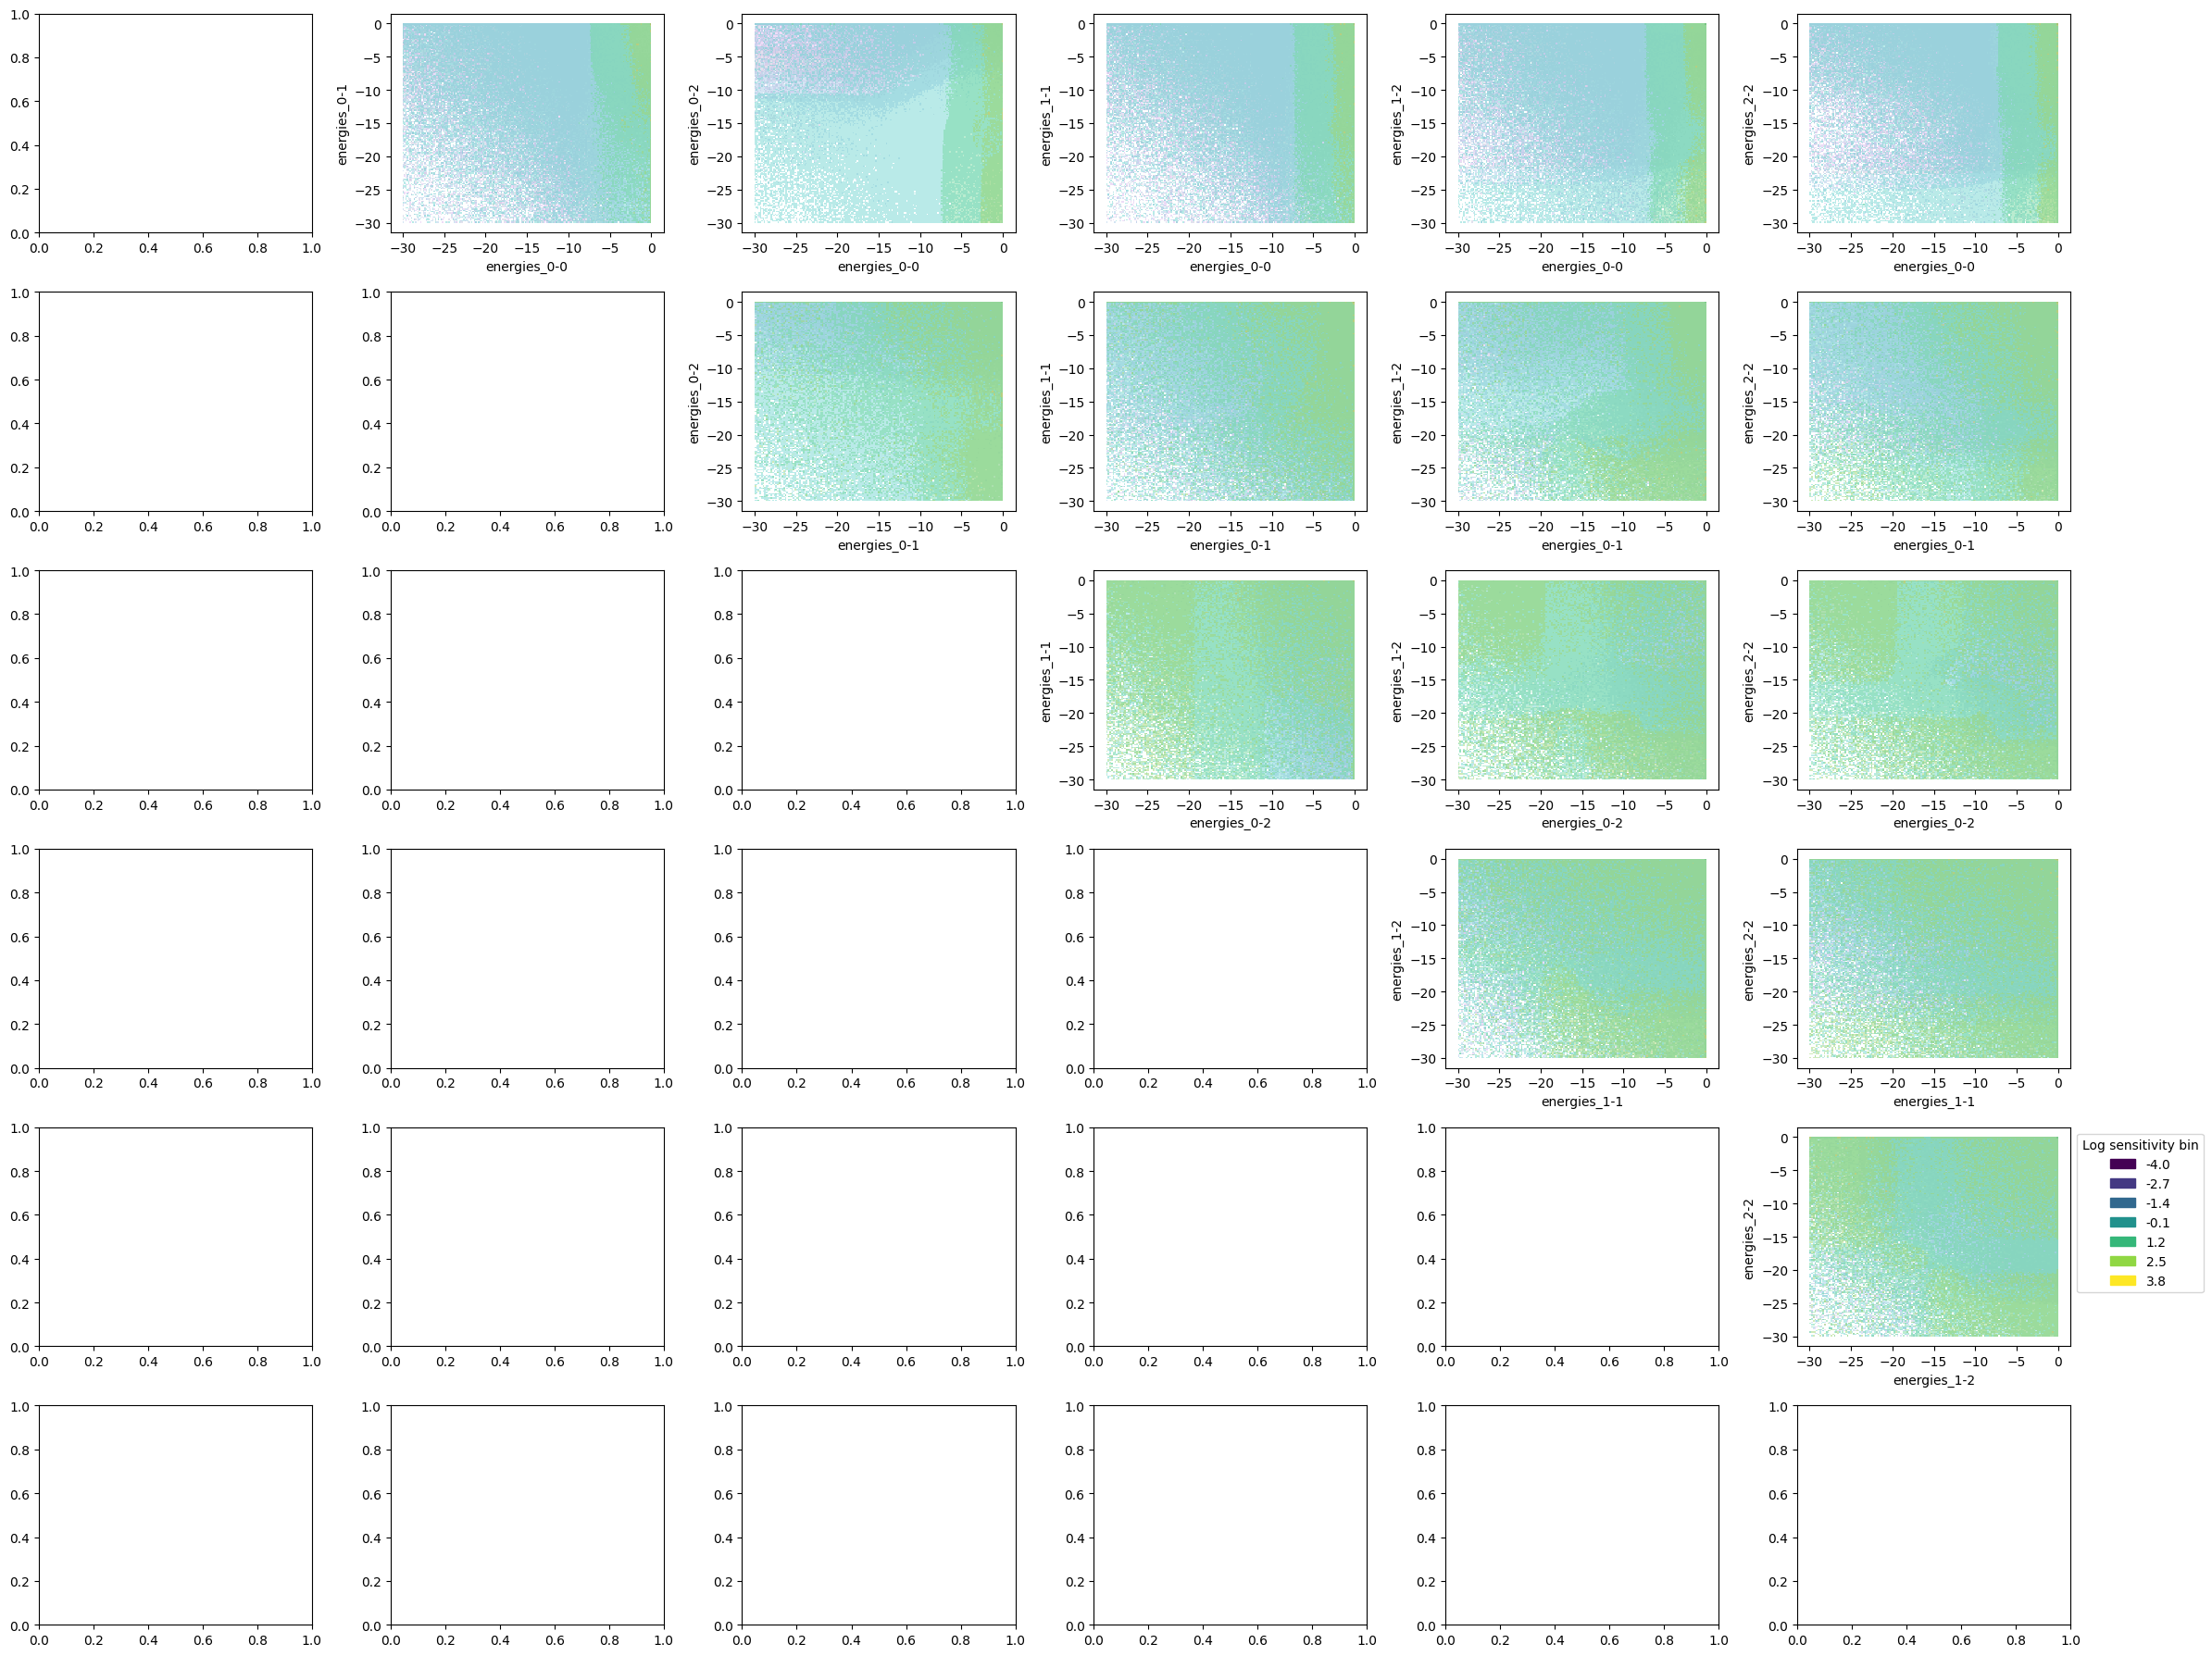

In [ ]:
data['Log sensitivity bin'] = pd.cut(data['Log sensitivity'], bins=10)
data['Log sensitivity bin'] = data['Log sensitivity bin'].apply(lambda x: np.round(x.mid, 1)).astype(float)

cols_e = get_true_interaction_cols(data, 'energies', remove_symmetrical=True)
combos_e = list(itertools.combinations(cols_e, 2))
nrows = len(cols_e)
cols = len(cols_e)
fig, axes = plt.subplots(nrows, cols, figsize=(3*cols, 2*nrows))
filt_d = (data['sample_name'] == 'RNA_2') & (data['Log sensitivity'] > -5) & (data['Log sensitivity'] < 3) & (~data['Log precision'].isna())
for i, (k1, k2) in enumerate(combos_e):
    ax = axes[cols_e.index(k1), cols_e.index(k2)]
    sns.histplot(data[filt], x=k1, y=k2, hue='Log sensitivity bin', palette='viridis', ax=ax, legend=False if i < len(combos_e) - 1 else True, alpha=0.5)
    if ax.get_legend() is not None:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

In [60]:
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import plotly.express as px

def latin_hypercube_sampling(num_params, param_bounds, num_samples=1000):
    samples = np.zeros((num_samples, num_params))
    for i, (lower, upper) in enumerate(param_bounds):
        samples[:, i] = np.random.uniform(lower, upper, num_samples)
    
    # Shuffle to ensure stratified sampling
    for j in range(num_params):
        np.random.shuffle(samples[:, j])
    
    return samples

def reduce_dimensionality(df, n_components=2):
    X = df.values
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP
    reducer = umap.UMAP(n_components=n_components)
    X_reduced = reducer.fit_transform(X_scaled)
    
    # Add reduced coordinates to original DataFrame
    df['UMAP_1'] = X_reduced[:, 0]
    df['UMAP_2'] = X_reduced[:, 1]
    
    return df

def cluster_parameter_groups(df, eps=0.5, min_samples=5):
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = clusterer.fit_predict(df[['UMAP_1', 'UMAP_2']])
    
    return df

def visualize_results(df, hue='cluster'):
    fig = px.scatter(
        df, 
        x='UMAP_1', 
        y='UMAP_2', 
        color=hue, 
        hover_data=[col for col in df.columns if col.startswith('param_')],
        title='Parameter Space Exploration'
    )
    # Set square dimensions and adjust layout
    fig.update_layout(
        width=600,  # Equal width and height
        height=600,
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=50, r=50, t=50, b=50)
    )
    return fig

# Create and run analysis
filt_d = filt_d & (data['Log sensitivity'] > -4)
results = data[filt_d][cols_e + ['Log sensitivity', 'Log precision']].iloc[:10000]
reduced_results = reduce_dimensionality(results)
clustered_results = cluster_parameter_groups(reduced_results, min_samples=100)
# visualization = visualize_results(clustered_results)
# visualization.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

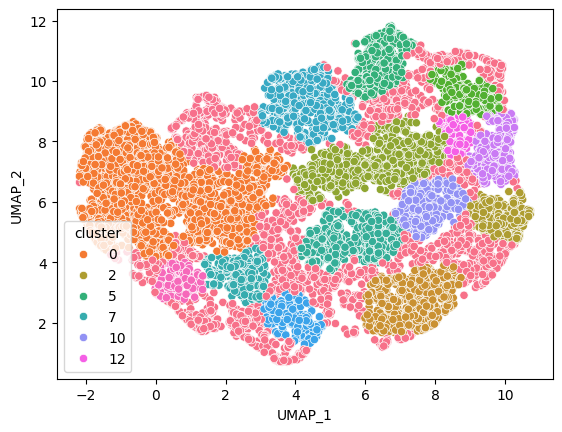

In [62]:
sns.scatterplot(clustered_results, x='UMAP_1', y='UMAP_2', hue='cluster', palette='husl')

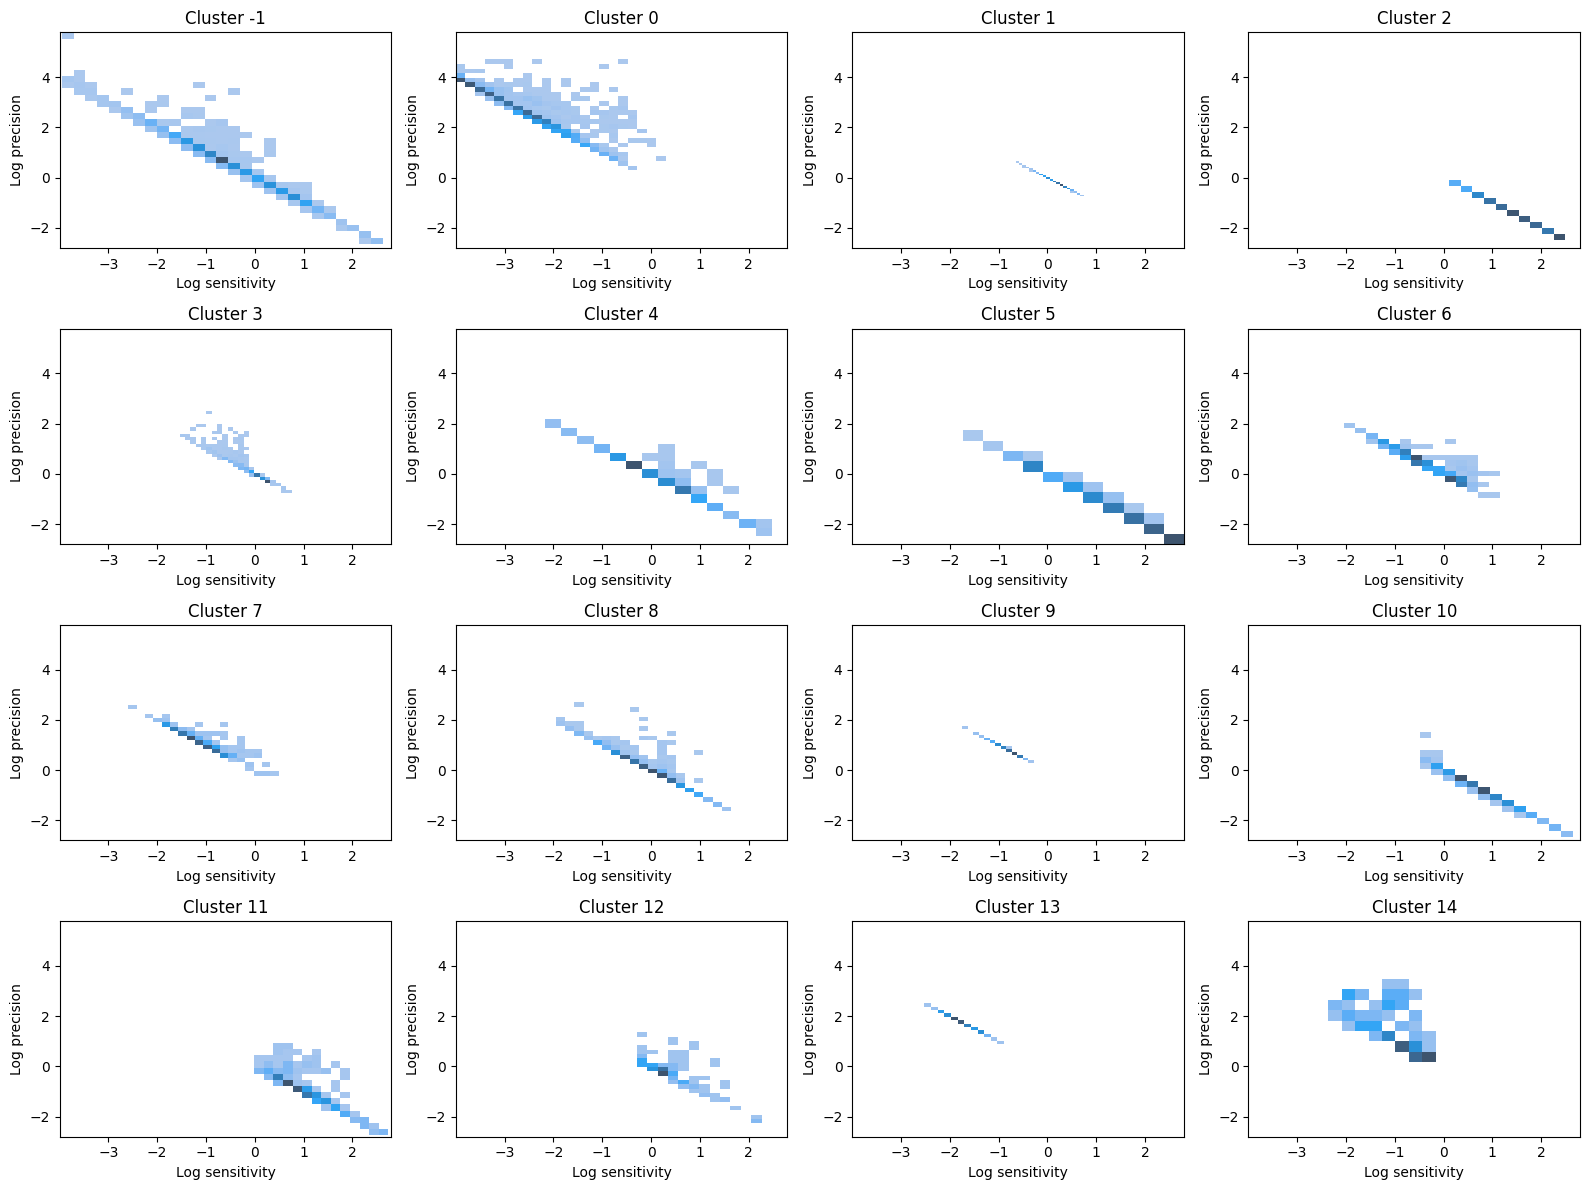

In [73]:
clusters = sorted(clustered_results['cluster'].unique())
nrows = int(np.ceil(np.sqrt(len(clusters))))
ncols = int(np.ceil(np.sqrt(len(clusters))))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
for i, cluster in enumerate(clusters):
    ax = axes.flatten()[i]
    filt = clustered_results['cluster'] == cluster
    sns.histplot(clustered_results[filt], x='Log sensitivity', y='Log precision', ax=ax)
    ax.set_xlim(clustered_results['Log sensitivity'].min(), clustered_results['Log sensitivity'].max())
    ax.set_ylim(clustered_results['Log precision'].min(), clustered_results['Log precision'].max())
    ax.set_title(f'Cluster {cluster}')
plt.tight_layout()

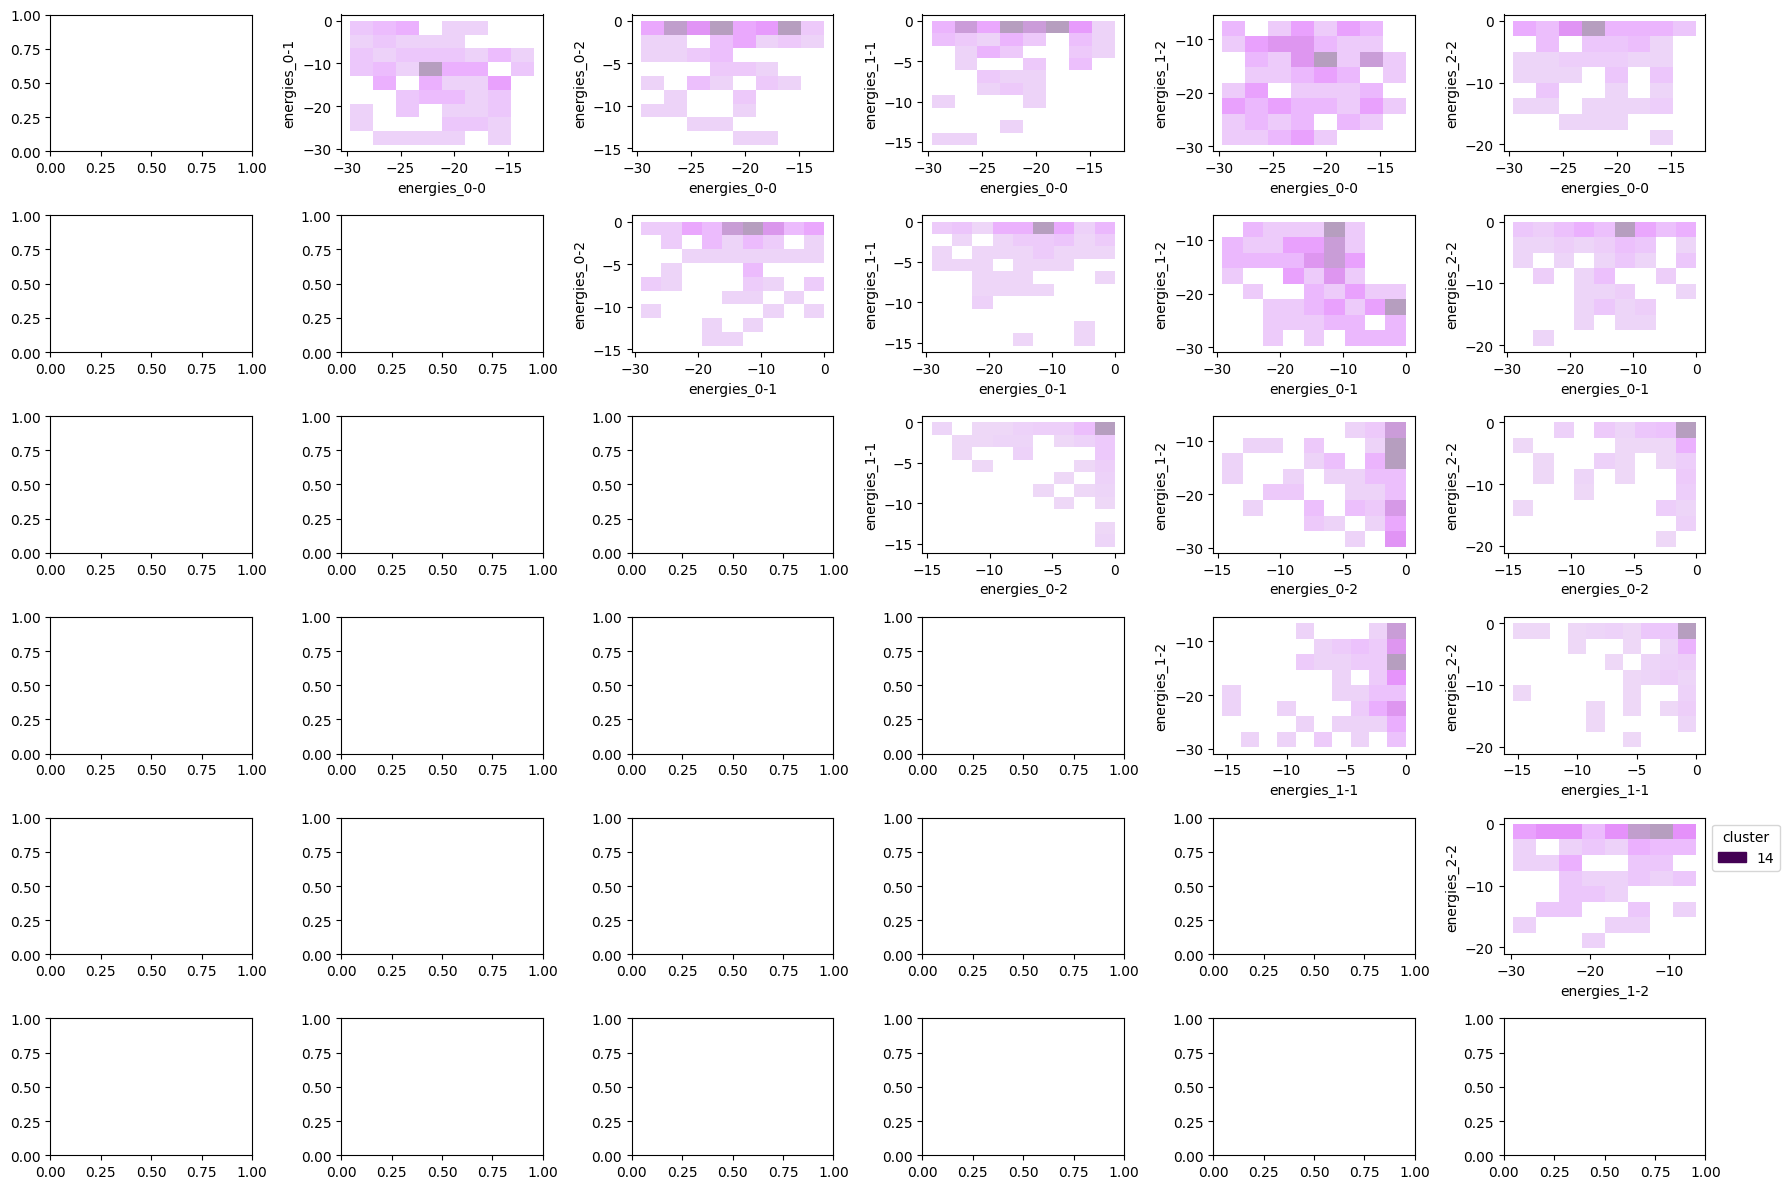

In [72]:
nrows = len(cols_e)
cols = len(cols_e)
fig, axes = plt.subplots(nrows, cols, figsize=(3*cols, 2*nrows))
for i, (k1, k2) in enumerate(combos_e):
    ax = axes[cols_e.index(k1), cols_e.index(k2)]
    c_i = clustered_results[clustered_results['cluster'] == 14]
    sns.histplot(c_i, x=k1, y=k2, hue='cluster', palette='viridis', ax=ax, legend=False if i < len(combos_e) - 1 else True, alpha=0.5)
    if ax.get_legend() is not None:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()